In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Project

/content/drive/My Drive/Project


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
data_dir = '/content/drive/My Drive/Project/data'

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1771


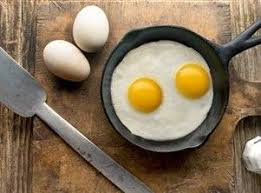

In [ ]:
kosharies = list(data_dir.glob('beed/*'))
PIL.Image.open(str(kosharies[0]))

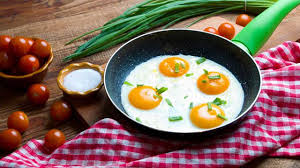

In [ ]:
PIL.Image.open(str(kosharies[1]))

# Loading Data

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 1816 files belonging to 12 classes.
Using 1453 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 1816 files belonging to 12 classes.
Using 363 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Mahshi', 'Molokhia', 'Om_Ali', 'baba ganoush', 'beed', 'besela', 'fteer', 'katayf', 'konafa', 'ms23a', 'sogo2', 'zalabya']


In [ ]:
classes_len = len(class_names)

# Visualize the data

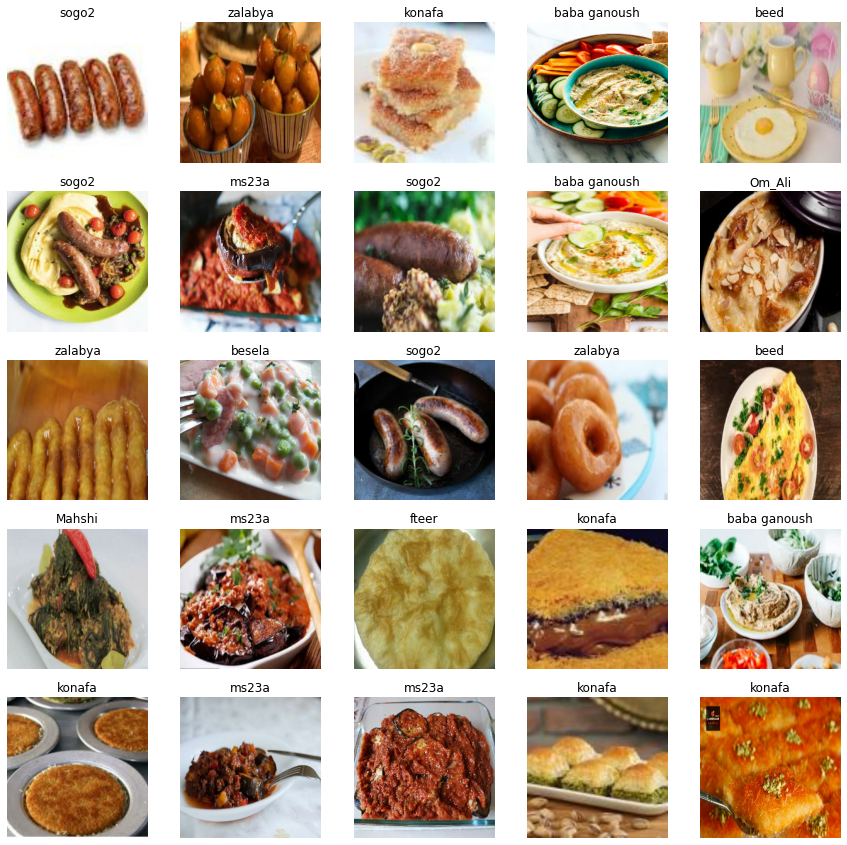

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(4000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

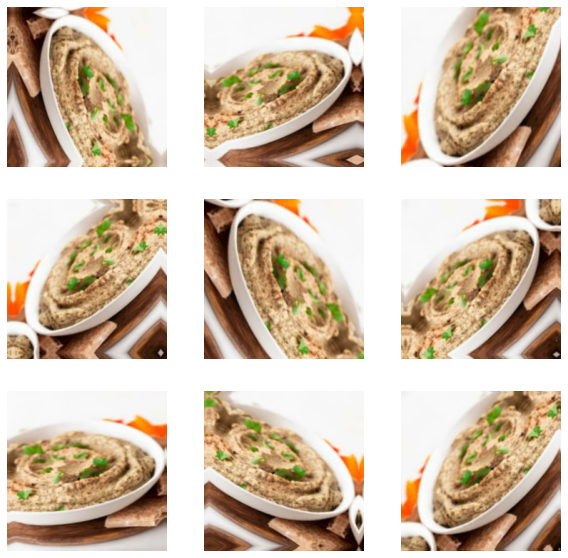

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Model

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_15[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(classes_len, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 12)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_8 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_8 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1280)              0   

In [ ]:
len(model.trainable_variables)

2

# Training

In [ ]:
model.evaluate(val_ds)

6/6 [==============================] - 3s 164ms/step - loss: 2.9062 - accuracy: 0.0771


[2.9062137603759766, 0.07713498920202255]

In [ ]:
initial_epochs = 25
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/25
23/23 [==============================] - 5s 116ms/step - loss: 2.9159 - accuracy: 0.0867 - val_loss: 2.5209 - val_accuracy: 0.1598
Epoch 2/25
23/23 [==============================] - 2s 96ms/step - loss: 2.6252 - accuracy: 0.1334 - val_loss: 2.3247 - val_accuracy: 0.2397
Epoch 3/25
23/23 [==============================] - 2s 95ms/step - loss: 2.4527 - accuracy: 0.1864 - val_loss: 2.1596 - val_accuracy: 0.2782
Epoch 4/25
23/23 [==============================] - 2s 96ms/step - loss: 2.2346 - accuracy: 0.2476 - val_loss: 2.0188 - val_accuracy: 0.3333
Epoch 5/25
23/23 [==============================] - 2s 96ms/step - loss: 2.1108 - accuracy: 0.2785 - val_loss: 1.8880 - val_accuracy: 0.3719
Epoch 6/25
23/23 [==============================] - 2s 95ms/step - loss: 1.9916 - accuracy: 0.3363 - val_loss: 1.7767 - val_accuracy: 0.4435
Epoch 7/25
23/23 [==============================] - 2s 95ms/step - loss: 1.8657 - accuracy: 0.3879 - val_loss: 1.6720 - val_accuracy: 0.4876
Epoch 8/25
2

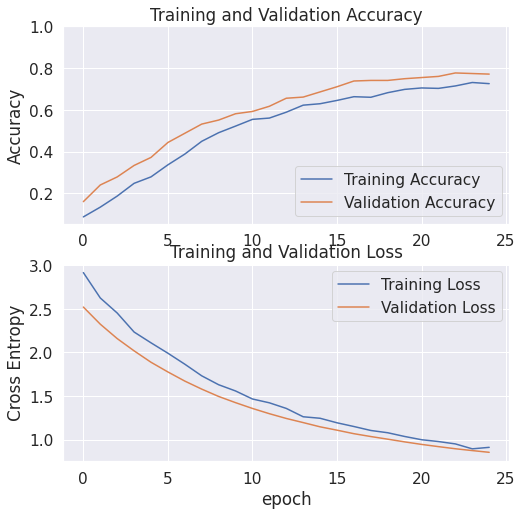

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(val_ds)

6/6 [==============================] - 0s 69ms/step - loss: 0.8554 - accuracy: 0.7713


[0.8553589582443237, 0.7713498473167419]

# Fine Tuning

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_8 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_8 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1280)              0   

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 25/50
23/23 [==============================] - 8s 175ms/step - loss: 0.7783 - accuracy: 0.7455 - val_loss: 0.5997 - val_accuracy: 0.8154
Epoch 26/50
23/23 [==============================] - 3s 130ms/step - loss: 0.6383 - accuracy: 0.7999 - val_loss: 0.5481 - val_accuracy: 0.8375
Epoch 27/50
23/23 [==============================] - 3s 131ms/step - loss: 0.5884 - accuracy: 0.7999 - val_loss: 0.5092 - val_accuracy: 0.8485
Epoch 28/50
23/23 [==============================] - 3s 130ms/step - loss: 0.5392 - accuracy: 0.8239 - val_loss: 0.4825 - val_accuracy: 0.8567
Epoch 29/50
23/23 [==============================] - 3s 132ms/step - loss: 0.4679 - accuracy: 0.8459 - val_loss: 0.4460 - val_accuracy: 0.8623
Epoch 30/50
23/23 [==============================] - 3s 131ms/step - loss: 0.4705 - accuracy: 0.8466 - val_loss: 0.4251 - val_accuracy: 0.8705
Epoch 31/50
23/23 [==============================] - 3s 130ms/step - loss: 0.4438 - accuracy: 0.8521 - val_loss: 0.4239 - val_accuracy: 0.8733

In [ ]:
# اfine_tune_epochs = 30
# total_epochs =  initial_epochs + fine_tune_epochs + 10

# history_fine = model.fit(train_ds,
#                          epochs=total_epochs,
#                          initial_epoch=history_fine.epoch[-1],
#                          validation_data=val_ds)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

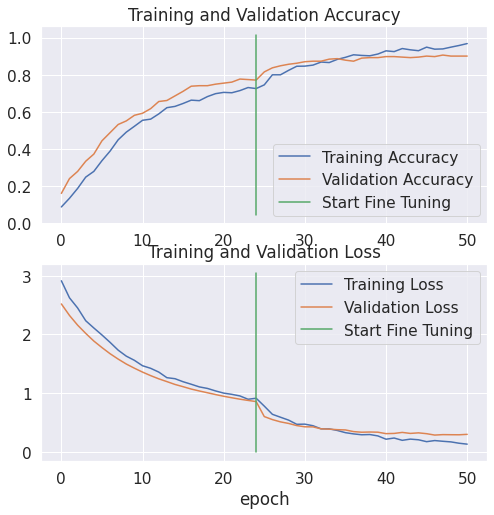

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(val_ds)

6/6 [==============================] - 0s 78ms/step - loss: 0.2965 - accuracy: 0.9008


[0.2965148985385895, 0.9008264541625977]

In [ ]:
model.evaluate(train_ds)

23/23 [==============================] - 2s 74ms/step - loss: 0.0967 - accuracy: 0.9773


[0.09669959545135498, 0.9773039817810059]

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
%matplotlib inline

def plot_confusion_matrix(true_labels, predictions, class_names):
  data = confusion_matrix(true_labels, predictions)
  df_cm = pd.DataFrame(data, columns=class_names, index = class_names)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (15,15))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

In [ ]:
predictions = np.array([])
true_labels =  np.array([])
for x, y in train_ds:
  batch_scores = model.predict(x)
  predictions = np.concatenate([predictions, np.argmax(batch_scores, axis=-1)])
  true_labels = np.concatenate([true_labels, y.numpy()])

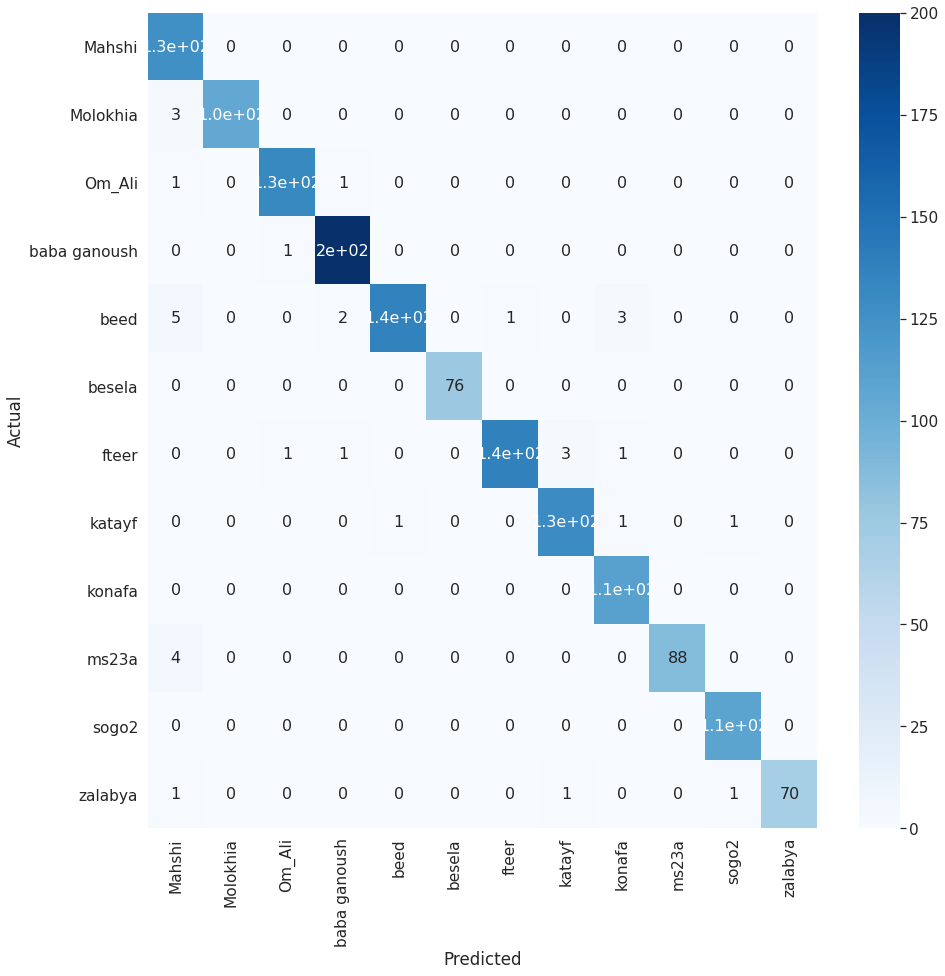

In [ ]:
plot_confusion_matrix(true_labels, predictions, class_names)

In [ ]:
flase_ids = (predictions != true_labels)
print(np.sum(flase_ids), 'wrong labels out of', len(flase_ids))

33 wrong labels out of 1454


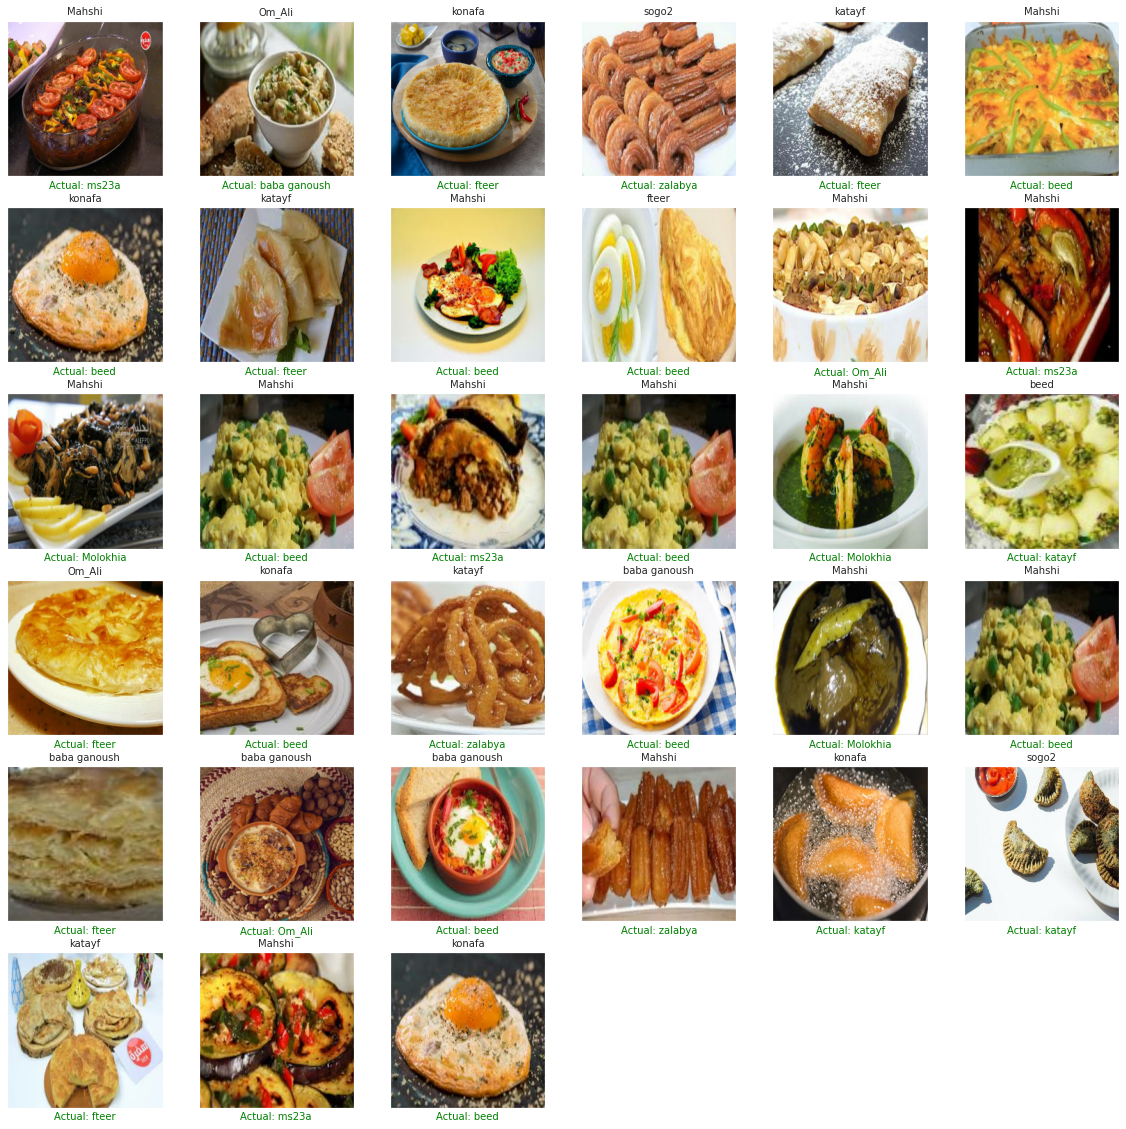

In [ ]:
# TRAIN
imgs_len = np.sum(flase_ids)
dim = int( np.sqrt(imgs_len) ) + 1

plt.figure(figsize=(20, 20))
counter_plot = 0

for images, labels in train_ds:
  b_size = labels.numpy().size
  preds = np.argmax(model.predict(images), axis=-1)
  for i in range(b_size):
    if int(preds[i]) == labels[i].numpy():
      continue
      
    counter_plot += 1
    ax = plt.subplot(dim, dim, counter_plot)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.xlabel('Actual: ' + class_names[labels[i]], color='green', fontsize=10)
    plt.title(class_names[ int(preds[i]) ], fontsize=10)
    # plt.axis("off")
    plt.xticks([])
    plt.yticks([])

In [ ]:
predictions = np.array([])
true_labels =  np.array([])
for x, y in val_ds:
  batch_scores = model.predict(x)
  predictions = np.concatenate([predictions, np.argmax(batch_scores, axis=-1)])
  true_labels = np.concatenate([true_labels, y.numpy()])

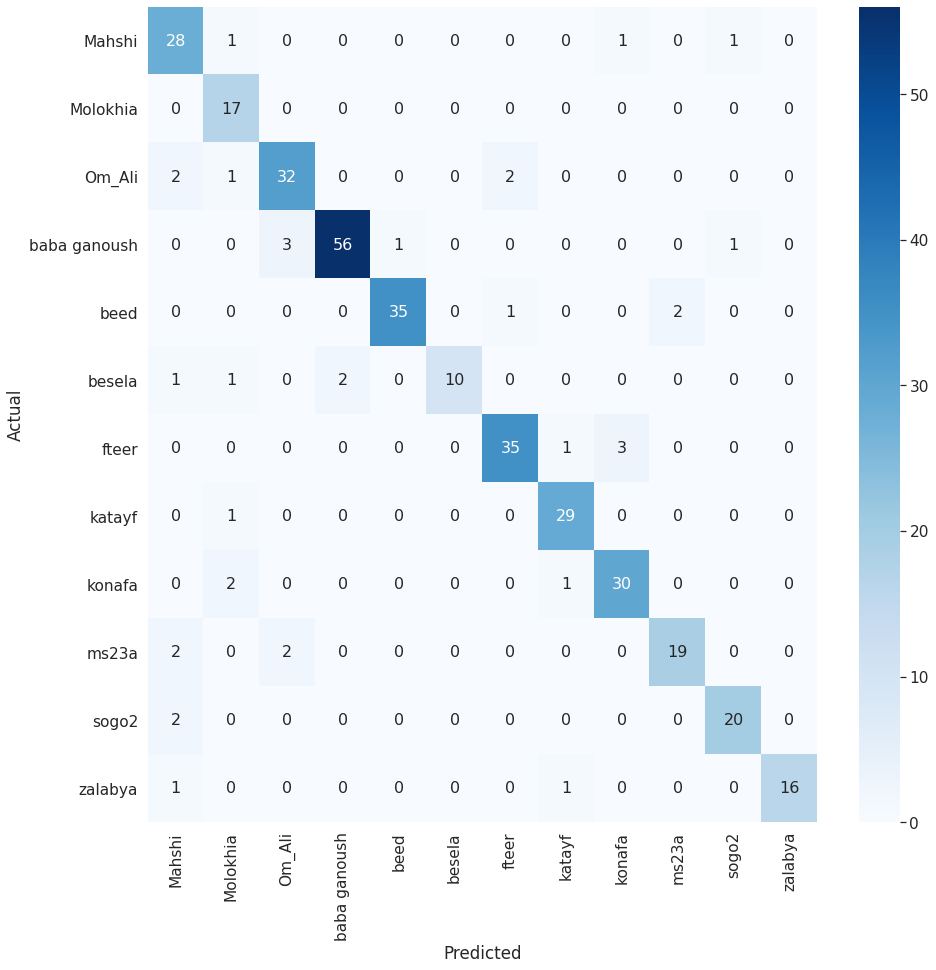

In [ ]:
plot_confusion_matrix(true_labels, predictions, class_names)

In [ ]:
flase_ids = (predictions != true_labels)
print(np.sum(flase_ids), 'wrong labels out of', len(flase_ids))

36 wrong labels out of 363


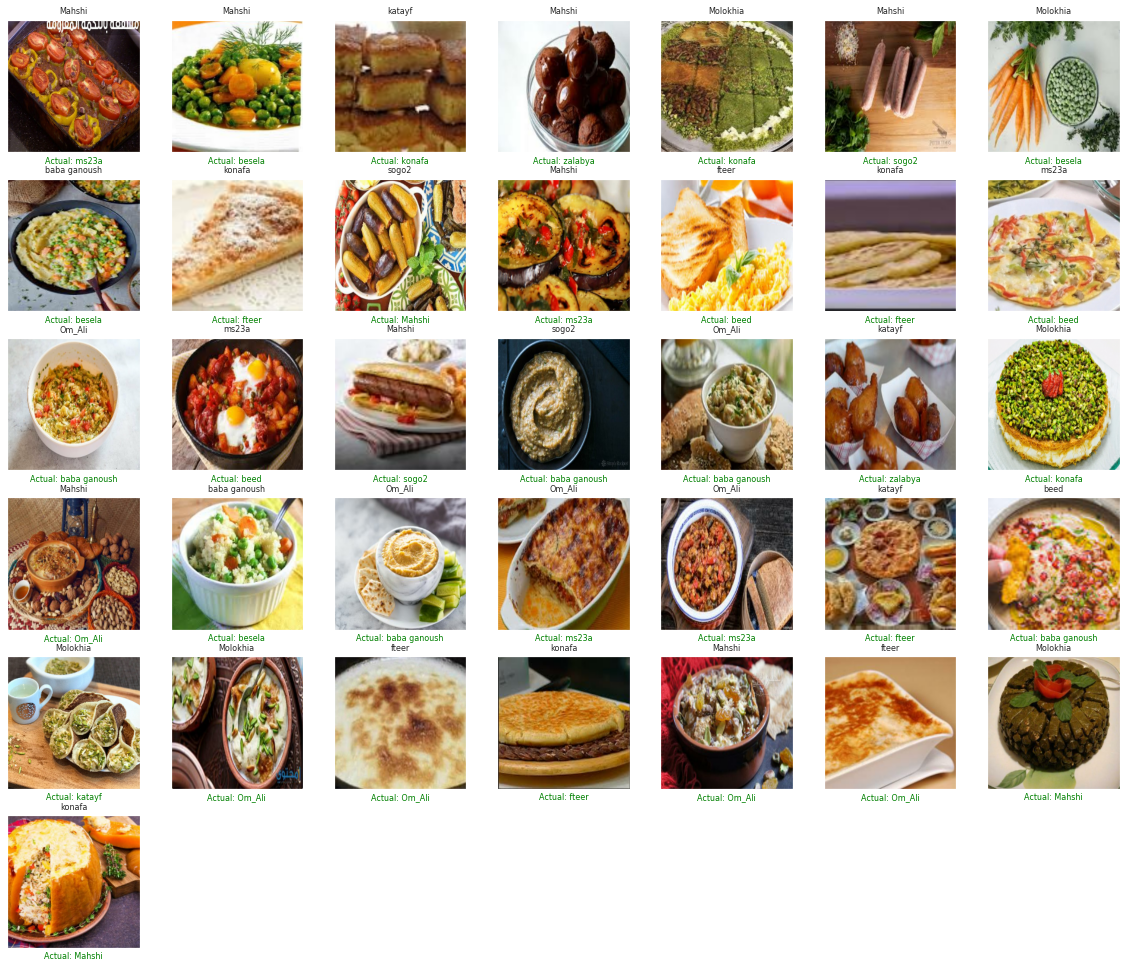

In [ ]:
# VAL
imgs_len = np.sum(flase_ids)
dim = int( np.sqrt(imgs_len) ) + 1

plt.figure(figsize=(20, 20))
or_index = - BATCH_SIZE
counter_plot = 0
for images, labels in val_ds:
  b_size = labels.numpy().size
  or_index += BATCH_SIZE
  for i in range(b_size):
    if flase_ids[or_index + i] == False:
      continue
    counter_plot += 1
    ax = plt.subplot(dim, dim, counter_plot)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.xlabel('Actual: ' + class_names[labels[i]], color='green', fontsize=8)
    assert(labels[i] == true_labels[or_index + i])
    plt.title(class_names[int( predictions[or_index + i] ) ], fontsize=8)
    # plt.axis("off")
    plt.xticks([])
    plt.yticks([])

In [ ]:
model.save('model_2.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
